# Mini-Project
## Logistic Regression and SVM Modeling of LendingClub Data
### Ricco Ferraro, David Grijalva, Nicole Norelli, & Mingyang Nick Yu
The data used in this analysis is from LendingClub, a peer-to-peer lending company. (Data from Kaggle.) Our goal is to accurately predict loan outcomes. Correctly predicting if a borrower will default on a loan is valuable information for investors as well as the LendingClub company itself. Loan outcome is a variable we created indicating whether the loan is good ("fully paid", "current", "in grace period", and "issued") or bad ("charged off", "late", and "default"). The following analysis uses information from the data set about the borrower, loan terms, and loan outcomes to build two models to predict loan outcome. The first model was built using logistic regression, and the second with support vector machines.

https://www.kaggle.com/ethon0426/lending-club-20072020q1

https://www.lendingclub.com 


In [1]:
import pandas as pd
import numpy as np
import warnings
import sklearn
import plotly.express as px
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,plot_confusion_matrix,plot_roc_curve
from sklearn.svm import SVC
import pickle
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from IPython.core.display import display, HTML
from sklearn.metrics import  auc, roc_curve
warnings.filterwarnings("ignore")

# Notebook options
pd.options.display.max_rows = 99999
pd.options.display.max_columns = 99999

In [2]:
%time data = pd.read_pickle("loan_100k_sample_520.pkl")

CPU times: user 29.6 ms, sys: 28.5 ms, total: 58.1 ms
Wall time: 56.6 ms


#### Further Data Cleaning
We explored and cleaned our data set during Project 1. We began this analysis with 100,000 instances and 54 variables. We removed nine additional variables before we began building our models:

`loan_status`: This variable was used to build our response variable (`good_loan_or_not`) so it was necessary to remove it from the explanatory variables.  

`issue_d`, `earliest_cr_line`, `last_pymnt_d`: These variables are dates and are not useful in their current format for this analysis.

`debt_settlement_flag`, `recoveries`, `total_rec_late_fee`, `delinq_amnt`: Further exploratory data analysis for this project illustrated that these four variables are nearly perfect predictors for bad loan. They each occurred only when a loan is already late or charged off. We decided these would not be practical from a prediction standpoint. Our goal was to predict a bad outcome before it happens, and these only occur afterwards.  

`out_prncp`, `total_rec_princp`: These two variables, in combination with `total_loan_amnt`, almost perfectly predicted our response. When `total_rec_princp` was equal to the total loan, the loan had been fully paid. When `total_rec_princp` plus `out_prncp` was equal to the total loan, it was current. However, when the combination of the two did not equal the total loan, the loan was charged off (bad status). This was because `out_prncp` was set to zero once the charge off occurred. This information was not useful from a prediction standpoint because it would only be available after a loan was fully paid or a charge off occurred.

`addr_state`: Our exploratory data analysis indicated that the home state of the loan applicant did not have a strong relationship with loan outcome. We decided the additional 50 levels it would have added to the model were not necessary for a variable with little relationship to the outcome.

We also removed `good_loan_or_not` from our explanatory variables because it is the response we are predicting.

Finally, we removed one instance because it was the only instance of `home_ownership` with a value of "none."

In [3]:
# Drop variables that perfectly colinears with good_loan_or_not
variables_indicate_bad_loan = ["debt_settlement_flag","recoveries","total_rec_late_fee",
                            "delinq_amnt","out_prncp","total_rec_prncp"]
data.drop(variables_indicate_bad_loan,inplace=True,axis=1)
# Drop only observation with home_ownership = 'NONE'
data.drop(23622,inplace=True,axis=0)

In [4]:
# Create X y variables with addr_state excluded
# good_loan_or_not is response, and it derives from loan_status
# issue_d, earliest_cr_line, and last_pymnt_d are dates format and they are
# converted into other formats to be useful.
X, y = data.drop(["addr_state","good_loan_or_not","loan_status","issue_d","earliest_cr_line","last_pymnt_d",
                  ], axis=1), data.good_loan_or_not
# X.info()

#### Initial train/test 80/20 data split for model selection with logistic regression and SVM
We conducted a train/test stratified split for logistic and SVM models. This allows us to use the same splits for all models we construct in this analysis, making comparisons among them more meaningful.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101, stratify=y)

# extract categorical vs numerical column names:
categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
numeric_ix = X.select_dtypes(include=['float','int']).columns

#### Define get_acc_score and get_classification_report functions:

In [6]:
def get_acc_score(model, x, y):
    return model.score(x, y)
  
def plot_roc_curve_custom(y_test, yPred):
    fpr, tpr, _ = roc_curve(y_test, yPred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Randomized Search CV (AUC = ' + str(round(roc_auc, 5)) + ')')
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
def get_classification_report(x_train, y_train, x_test, y_test, pred, model):
    """
    This function is used to get comprehensive classification report:
    Training Accuracy, Test Accuracy, print classification_report
    plot confusion matrix, and plot roc curve.
    """
    print(f"Train accuracy: {get_acc_score(model, x_train, y_train):,.5f}")
    print("Test result:")
    print(classification_report(y_test,pred))
    plot_roc_curve_custom(y_test, pred)
    plot_confusion_matrix(model, x_test, y_test,colorbar=False)
    fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label=1)
    print(f"Test AUC: {auc(fpr, tpr):,.5f}")
def get_auc(y_test, pred):
    
    fpr, tpr, _ = roc_curve(y_test, pred, pos_label=1)
    roc_auc = auc(fpr, tpr)
    return roc_auc

## Create Models

####  Set hyperparameters, reference levels, and cv method for modeling:

In [7]:
params_lr = {
    "model__max_iter": [10000],
    "model__n_jobs":[-1],
    "model__penalty": ["l2"],
    "model__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "model__fit_intercept": [True, False],
    "model__solver": ["lbfgs","liblinear","saga"],
    "model__class_weight":[None,"balanced"]
}


params_svc = {
    "model__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "model__gamma": ["scale", "auto", 1, 0.1, 0.01, 0.001, 0.0001],
    "model__kernel":["linear", "poly", "rbf"],
    "model__class_weight":[None,"balanced"]
}

# Categories to drop
reference_levels_to_drop = [
    [ ' 36 months'],
    ['A'],
    ['< 1 year'],
    ['ANY'],
    ['Not Verified'],
    ['other'],
    ['Individual'],
    ['N']
]

# CV method
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

def cv_summary(estimator, columns):
    df = pd.DataFrame(estimator.cv_results_)
    cv_result_summary = df[columns]
    cv_result_summary.index  = np.arange(1,len(cv_result_summary)+1)
    cv_result_summary = cv_result_summary.reset_index()
    cv_result_summary = cv_result_summary.rename(columns = {
        "index": "param_combination", "mean_test_score": "mean_validation_score",
        "rank_test_score": "rank_validation_score"
    })
    return cv_result_summary

For logistic regression, we compared models with different combinations of the parameters cost, intercept, algorithm, and class weight.  
`params_lr` contains the different values for each of these parameters.

For SVM, we compared models with different combinations of the parameters cost, gamma, kernel, and class weight.  
`params_svc` contains the different values for each of these parameters.  

We selected specific reference levels to drop for one hot encoded categorical variables to make any future interpretations easier.  

We established our cross validation method as a stratified 10-fold split.

Finally, we created `cv_summary` function to print custom overall RandomSearchCV results.

### Logistic Regression: scaled numeric variables

We utilized Pipeline to one hot encode the categorical variables and then scale numeric variables using StandardScaler for the preprocessing step. We defined custom reference levels to drop under the OneHotEncoder to prevent multicollinearity in the model building for logistic regression. We used RandomizedSearchCV instead of GridSearch to improve efficiency. The RandomizedSearchCV randomly selected ten combinations of parameters from the parameters dictionary (`params_lr`). Each selected combination of parameters was evaluated through a 10-fold cross validation on the training data. We chose area under the curve (roc_auc) for performance evaluation because we wanted to maximize the precision of predicting both good loans and bad loans. The best combination of parameters was then selected using roc_auc score and was fitted to our training data under the variable "search_lr_scaled." We evaluated this model's performance on the test set for comparison with other models in this analysis.

In [8]:
%%time

# Define preprocessing for columns
t = [('cat', OneHotEncoder(drop = reference_levels_to_drop), categorical_ix), ('scale',StandardScaler(), numeric_ix)]
col_transform = ColumnTransformer(t)
model_lr_scaled = LogisticRegression(random_state=111)
pipeline_lr_scaled = Pipeline(steps=[('preprocessing',col_transform), ('model', model_lr_scaled)])

#Fit
clf_lr_scaled = RandomizedSearchCV(pipeline_lr_scaled, params_lr, n_iter=10, scoring='roc_auc',
                                   random_state=123, verbose=5, cv=cv, n_jobs=-1,return_train_score=True)
search_lr_scaled = clf_lr_scaled.fit(X_train, y_train)
search_lr_scaled.best_params_

Fitting 10 folds for each of 10 candidates, totalling 100 fits
CPU times: user 6.59 s, sys: 1.61 s, total: 8.2 s
Wall time: 11min 56s


{'model__solver': 'lbfgs',
 'model__penalty': 'l2',
 'model__n_jobs': -1,
 'model__max_iter': 10000,
 'model__fit_intercept': True,
 'model__class_weight': 'balanced',
 'model__C': 10}

__Exploration of parameter combinations and model changes:__

In [9]:
# Get cross validation result
best_logistic_scaled_columns = ['param_model__solver',"param_model__C","param_model__fit_intercept",
                                "param_model__class_weight","mean_test_score","rank_test_score"]
df_best_logistic_scaled_cv_results = cv_summary(search_lr_scaled, best_logistic_scaled_columns)
df_best_logistic_scaled_cv_results

param_combination param_model__solver param_model__C  \
0                  1               lbfgs            100   
1                  2                saga            0.1   
2                  3                saga            100   
3                  4                saga            100   
4                  5                saga           0.01   
5                  6                saga          0.001   
6                  7           liblinear             10   
7                  8           liblinear            100   
8                  9                saga            0.1   
9                 10               lbfgs             10   

  param_model__fit_intercept param_model__class_weight  mean_validation_score  \
0                      False                      None               0.970828   
1                       True                      None               0.970545   
2                      False                  balanced               0.971100   
3                      False                      None               0.970149   
4                      False                  balanced               0.967685   
5                       True                  balanced               0.963977   
6                      False                      None               0.970815   
7                      False                      None               0.970827   
8                      False                      None               0.969075   
9                       True                  balanced               0.971856   

   rank_validation_score  
0                      3  
1                      6  
2                      2  
3                      7  
4                      9  
5                     10  
6                      5  
7                      4  
8                      8  
9                      1

Because we used RandomizedSearchCV rather than GridSearch to save time, we can only examine ten random combinations of parameters. Although it is not comprehensive, we can see some trends. For example, we tried cost parameters ranging from values of .001 to 100. Increases in cost were associated with increases in mean validation score (roc_auc). The changes due to fitting an intercept and using different algorithms or class weights are more difficult to determine.

__Best parameters for logistic regression model (scaled version):__

The model with the best performance based on roc_auc score for the cross validated training data used the following parameters:  

Algorithm (solver): lbfgs  
Class weight: balanced  
Intercept: True  
Cost: 10  

Fit 10 folds for each of 10 candidates (total 100 fits) in 11min 56s.

__Performance of Logistic Regression (scaled version) best parameters on test set:__

Train accuracy: 0.97238
Test result:
              precision    recall  f1-score   support

           0       0.65      0.93      0.76      2483
           1       0.99      0.93      0.96     17517

    accuracy                           0.93     20000
   macro avg       0.82      0.93      0.86     20000
weighted avg       0.95      0.93      0.93     20000

Test AUC: 0.92828


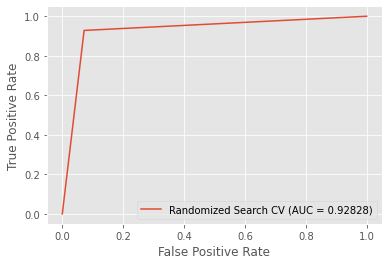

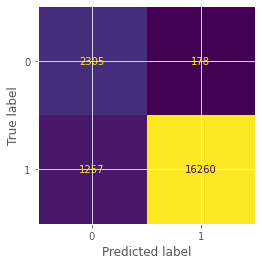

In [10]:
y_hat_lg_scaled = search_lr_scaled.predict(X_test)
get_classification_report(X_train, y_train, X_test, y_test, y_hat_lg_scaled, search_lr_scaled)

The scaled logistic regression model produces a training accuracy of 0.97238. The AUC for the test set is 0.92828. Recall for the positive class (good loan) is 0.93, and recall for the negative class (bad loan) is 0.93. With an unbalanced data set, creating a model that correctly identified the negative class was our biggest concern. This model correctly predicts 2305 of the 2483 "bad" loans.

### Logistic Regression: Not Scaled


To explore the effects of scaling or not scaling numeric variables on the selection of model parameters, we repeated the process above. Again, we utilized Pipeline to one hot encode the categorical variables, but we left numeric variables on their original scale. We defined custom reference levels to drop under the OneHotEncoder to prevent multicollinearity in the model building for logistic regression. We used RandomizedSearchCV instead of GridSearch to improve efficiency. The RandomizedSearchCV randomly selected ten combinations of parameters from the parameters dictionary (`params_lr`). Each selected combination of parameters was evaluated through a 10-fold cross validation on the training data. We chose area under the curve (roc_auc) for performance evaluation because we want to maximize the precision of predicting both good loans and bad loans. The best combination of parameters was then selected using roc_auc score and was fitted to our training data under the variable "search_lr_not_scaled." We evaluated this model's performance on the test set for comparison with other models in this analysis.

In [11]:
%%time

# Define preprocessing for columns
t = [('cat', OneHotEncoder(drop = reference_levels_to_drop), categorical_ix)]
col_transform = ColumnTransformer(t,remainder='passthrough')
model_lr_not_scaled = LogisticRegression(random_state=111)
pipeline_lr_not_scaled = Pipeline(steps=[('preprocessing',col_transform), ('model', model_lr_not_scaled)])

# Use RandomizedSearchCV and 10 fold cross validation to select the best model parameters
clf_lr_not_scaled = RandomizedSearchCV(pipeline_lr_not_scaled, params_lr, n_iter=10, scoring='roc_auc',
                                       random_state=123, verbose=5, cv=cv, n_jobs=-1,return_train_score=True)
search_lr_not_scaled = clf_lr_not_scaled.fit(X_train, y_train)
# Observe the best parameters
search_lr_not_scaled.best_params_

Fitting 10 folds for each of 10 candidates, totalling 100 fits
CPU times: user 6.76 s, sys: 1.7 s, total: 8.46 s
Wall time: 1h 1min 21s


{'model__solver': 'lbfgs',
 'model__penalty': 'l2',
 'model__n_jobs': -1,
 'model__max_iter': 10000,
 'model__fit_intercept': False,
 'model__class_weight': None,
 'model__C': 100}

__Exploration of parameter combinations and model changes:__

In [12]:
df_best_logistic_not_scaled_cv_results_columns = ['param_model__solver',"param_model__C","param_model__fit_intercept",
                                                "param_model__class_weight","mean_test_score","rank_test_score"]
df_best_logistic_not_scaled_cv_results = cv_summary(search_lr_not_scaled, df_best_logistic_not_scaled_cv_results_columns)
df_best_logistic_not_scaled_cv_results

param_combination param_model__solver param_model__C  \
0                  1               lbfgs            100   
1                  2                saga            0.1   
2                  3                saga            100   
3                  4                saga            100   
4                  5                saga           0.01   
5                  6                saga          0.001   
6                  7           liblinear             10   
7                  8           liblinear            100   
8                  9                saga            0.1   
9                 10               lbfgs             10   

  param_model__fit_intercept param_model__class_weight  mean_validation_score  \
0                      False                      None               0.964236   
1                       True                      None               0.647388   
2                      False                  balanced               0.727773   
3                      False                      None               0.647388   
4                      False                  balanced               0.727773   
5                       True                  balanced               0.727773   
6                      False                      None               0.963576   
7                      False                      None               0.963349   
8                      False                      None               0.647388   
9                       True                  balanced               0.963351   

   rank_validation_score  
0                      1  
1                      8  
2                      5  
3                      8  
4                      5  
5                      5  
6                      2  
7                      4  
8                      8  
9                      3

The same combinations of parameters using variables that have not been scaled produced different results. The effect of using the different algorithms (solvers) with unscaled variables is much more noticeable. The saga algorithm produced much better results when using scaled numeric variables. When we used unscaled variables, saga performed noticeably worse than the other algorithms. While the best performance was produced with the lbfgs algorithm once again, different parameters for cost, intercept, and class weight were were selected when compared with the scaled logistic model.

__Best parameters for logistic regression model (unscaled version):__

The model with the best performance based on roc_auc score for the cross validated training data used the following parameters:  

Algorithm (solver): lbfgs  
Class weight: None  
Intercept: False  
Cost: 100  

Fit 10 folds for each of 10 candidates (total 100 fits) in 1h 1min 21s.

__Performance of Logistic Regression (unscaled version) best parameters on test set:__

Train accuracy: 0.96352
Test result:
              precision    recall  f1-score   support

           0       0.80      0.71      0.75      2483
           1       0.96      0.98      0.97     17517

    accuracy                           0.94     20000
   macro avg       0.88      0.84      0.86     20000
weighted avg       0.94      0.94      0.94     20000

Test AUC: 0.84041


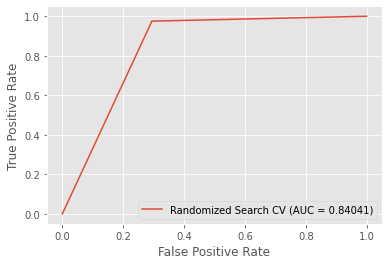

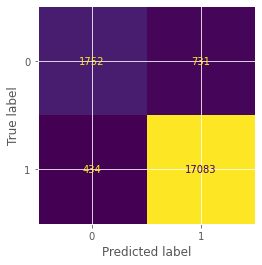

In [13]:
y_hat_lg_not_scaled = search_lr_not_scaled.predict(X_test)
get_classification_report(X_train, y_train, X_test, y_test, y_hat_lg_not_scaled, search_lr_not_scaled)

The unscaled logistic regression model produces a training accuracy of 0.96352. The AUC for the test set is 0.84041. Recall for the positive class (good loan) is 0.98, and recall for the negative class (bad loan) is 0.71. With an unbalanced data set, creating a model that correctly identified the negative class was our biggest concern. This model correctly predicts 1752 of the 2483 "bad" loans.

The unscaled logistic regression model performed worse than the model built using scaled numeric variables. The test AUC was lower (0.84041 vs. 0.92828) and the unscaled logistic regression had a much lower recall for the negative class (0.71 vs. 0.93). We will proceed with the scaled logistic regression model as our chosen logistic regression model.

### SVM Parameters Explored

To build our SVM model, we investigated different combinations of the parameters kernel, gamma, cost, and class weight.  

For kernel, we included rbf, poly, and linear.  
For gamma, we included scale, auto, 1, 0.1, 0.01, 0.001, and 0.0001.  
For C, we included 0.001, 0.01, 0.1, 1, 10, and 100  
For class weight, we included balanced and none.  

_Note:_ Setting "scale" for gamma uses 1/(nfeatures * X.var()) as gamma value

`params_svc` contains the different values for each of these parameters.

### SVM with scaled numeric variables

Once again, we utilized Pipeline to one hot encode the categorical variables and then scale numeric variables using StandardScaler for the preprocessing step. We defined custom reference levels to drop under the OneHotEncoder. We used RandomizedSearchCV instead of GridSearch to improve efficiency. The RandomizedSearchCV randomly selected ten combinations of parameters from the parameters dictionary (`params_svc`). Each selected combination of parameters was evaluated through a 10-fold cross validation on the training data. We chose area under the curve (roc_auc) for performance evaluation because we wanted to maximize the precision of predicting both good loans and bad loans. The best combination of parameters was then selected using roc_auc score and was fitted to our training data under the variable "search_svc." We evaluated this model's performance on the test set for comparison with other models in this analysis.

In [14]:
%%time

# define preprocessing for columns
t = [('cat', OneHotEncoder(drop = reference_levels_to_drop), categorical_ix), ('scale',StandardScaler(), numeric_ix)]
col_transform = ColumnTransformer(t)
model_svc = SVC()
pipeline_svc = Pipeline(steps=[('preprocessing',col_transform), ('model', model_svc)])

#Fit
clf_svc = RandomizedSearchCV(pipeline_svc, params_svc, n_iter=10, scoring='roc_auc',
                             random_state=123, verbose=5, cv=cv, n_jobs=-1,return_train_score=True)
search_svc = clf_svc.fit(X_train, y_train)
search_svc.best_params_

Fitting 10 folds for each of 10 candidates, totalling 100 fits
CPU times: user 1h 30min 9s, sys: 12 s, total: 1h 30min 21s
Wall time: 1d 16min 55s


{'model__kernel': 'linear',
 'model__gamma': 0.0001,
 'model__class_weight': 'balanced',
 'model__C': 10}

__Exploration of parameter combinations and model changes:__

In [15]:
df_search_svc_cv_results_columns = ['param_model__kernel',"param_model__gamma","param_model__class_weight",
                                    "param_model__C","mean_test_score","rank_test_score"]
df_search_svc_cv_results = cv_summary(search_svc, df_search_svc_cv_results_columns)
df_search_svc_cv_results

param_combination param_model__kernel param_model__gamma  \
0                  1              linear             0.0001   
1                  2              linear               auto   
2                  3                 rbf                0.1   
3                  4                poly                0.1   
4                  5                 rbf                0.1   
5                  6                poly                0.1   
6                  7                 rbf             0.0001   
7                  8                 rbf               0.01   
8                  9                 rbf              scale   
9                 10                poly               0.01   

  param_model__class_weight param_model__C  mean_validation_score  \
0                  balanced             10               0.971845   
1                      None            100               0.971630   
2                      None            100               0.949775   
3                  balanced          0.001               0.955682   
4                  balanced            100               0.949775   
5                      None              1               0.932953   
6                      None          0.001               0.960477   
7                  balanced             10               0.969284   
8                      None             10               0.964224   
9                  balanced             10               0.957479   

   rank_validation_score  
0                      1  
1                      2  
2                      8  
3                      7  
4                      8  
5                     10  
6                      5  
7                      3  
8                      4  
9                      6

Trends in the ten randomly selected combinations of parameters for SVM are more difficult to determine. While the two top performing models both used linear kernels, the random combinations chosen are not comprehensive enough to indicate if this happened by chance. To more clearly see the effects of each of the parameters, we would need to fit many more models, but SVM is quite time-intensive so we did not pursue a comprehensive combination of parameter options.

__Best parameters for SVM:__

The model with the best performance based on roc_auc score for the cross validated training data used the following parameters:  

Kernel: linear  
Gamma: 0.0001  
C: 10  
Class weight: balanced

Fit 10 folds for each of 10 candidates (total 100 fits) in 1d 16min 55s.

__Performance of SVM best parameters on test set:__

Train accuracy: 0.97227
Test result:
              precision    recall  f1-score   support

           0       0.66      0.93      0.77      2483
           1       0.99      0.93      0.96     17517

    accuracy                           0.93     20000
   macro avg       0.82      0.93      0.86     20000
weighted avg       0.95      0.93      0.94     20000

Test AUC: 0.92861


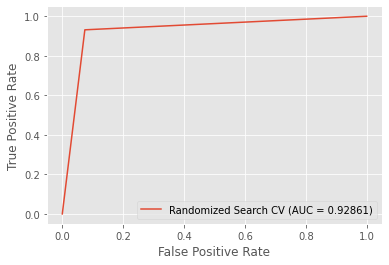

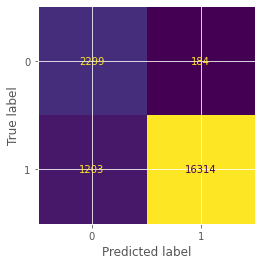

In [16]:
y_hat_svc = search_svc.predict(X_test)
get_classification_report(X_train, y_train, X_test, y_test, y_hat_svc, search_svc)

The SVM model produces a training accuracy of 0.97227. The AUC for the test set is 0.92861. Recall for the positive class (good loan) is 0.93, and recall for the negative class (bad loan) is 0.93. With an unbalanced data set, creating a model that correctly identified the negative class was our biggest concern. This model correctly predicts 2299 of the 2483 "bad" loans.

## Model Advantages

<h3>Overview</h3>

Logistic regression (LR) and Support vector machine (SVM) are two different supervised machine learning classification algorithms that are closely related but also have significant differences. The right choice of algorithm is really dependent on the end goal of the classification task and the  size of the training dataset. 

<br>

<b>Logistic regression explained</b>

Logistic regression is a supervised parametric model used for binary classification tasks. The inner workings of the model are similar to a linear regression with the main difference of predictions being passed to a sigmoid function in order to constrain predictions to be between 0 and 1. 
To find the best set of weights, logistic regression uses a cost function such as $Gradient Descent$ to find an approximation of the global minimum.


<b>Advantages</b>

- Provides a very easy way to interpret the model parameters. This includes a directionality measurement of positive or negative contribution of a parameter to the final prediction  
- There are no assumptions of normality for the dependent variable
- Very efficient training time 

<b> Disadvantages </b>

- Easy to overfit with smaller datasets
- Can't solve nonlinear problems due to being limited to a linear decision function
 - It is difficult to capture complex relations among features

<b>Support vector machine explained </b>

Support vector machine is an algorithm used to solve linear and non-linear classification problems. The goal of the  model is to optimize the margin between the two classes while minimizing the misclassification error. The model finds all the points near the boundary line, called <b>support vectors</b>, then it calculates the distance between the support vectors and the separation line in order to maximize the margin between the two classes.  

<b>Kernel trick<b/>

When the data does not have obvious separation between the two classes, SVM can take advantage of the kernel trick. Simply put, the kernel trick maps the data into $n-1$ dimensions. This makes it possible to find better separation of classes through a hyperplane.   


<b>Advantages</b>

- SVM is an efficient model for higher dimensional problems. This is beneficial when the classes are not linearly separable. 

- Outliers have less influence 

<b> Disadvantages </b>

- SVM is not a scalable solution for bigger datasets.  The model training time is significantly higher than other algorithms such as logistic regression. 

- It is not possible to do prediction interpretation. The train model does not return coefficients but rather support vectors. These are not useful for interpretation. 

- The kernel trick makes it easy to overfit the model. This is why it is important to perform cross validation.
       

In [17]:
def add_text(df,  model_type):
    if model_type == "lr":
        df['text'] = "Params Combination: #" + df.param_combination.astype(str) + "; Estimator Rank: " +df.rank_validation_score.astype(str) + ";Solver: " + df.param_model__solver.astype(str) \
        + " Penalty: " + df.param_model__penalty.astype(str) +  " C: " + df.param_model__C.astype(str) + " Intercept Fit: " + df.param_model__fit_intercept.astype(str) 
    elif model_type == "svm":
        df['text'] = "CV Iter:" + df.param_combination.astype(str) + "; Estimator Rank: " +df.rank_validation_score.astype(str) + ";Kernel: " + df.param_model__kernel.astype(str)
    return df

In [18]:
def plot(df, name):
    fig = make_subplots(
            rows=1, cols=2,
            subplot_titles = ("Mean Fit Time (Seconds)", "Mean CV Train/Validation Score (AUC)"))

    fig.add_trace(
        go.Scatter(y=df.mean_fit_time, x=df.param_combination),
        row=1, col=1)

    fig.add_trace(
        go.Scatter(y=df.mean_train_score, x=df.param_combination, opacity = 0.5, name="Train"),
        row=1, col=2
    )
    fig.append_trace(
        go.Scatter(y=df.mean_validation_score, x=df.param_combination, opacity = 0.5, name="Validation"),
        row=1, col=2
    )
    fig.update_traces(textposition='top center')
    fig.update_layout(showlegend=False, title_text=f"{name} Performance and Efficiency")
    fig.add_annotation(y=df[df["rank_validation_score"]==1].mean_fit_time.values[0], text="Best Fitted", x=df[df["rank_validation_score"]==1].param_combination.values[0])
    fig['layout']['xaxis']['title']='Hyperparameter Combinations'
    fig['layout']['yaxis']['title']='Seconds'
    fig['layout']['xaxis2']['title']='Hyperparameter Combinations'
    fig['layout']['yaxis2']['title']='AUC'
    #fig['layout']['annotations'][2].update(text="Best Fitted", x=df[df["rank_test_score"]==1].param_combination.values[0])
    fig.show()
    
    
    display(HTML(f"<h5>Best fit CV Validation AUC: {df[df['rank_validation_score']==1].mean_validation_score.values[0] * 100:.2f}"))
    display(HTML(f"<H5>Params Combinations Average 10-Fold CV Training time: {convert(df.mean_fit_time.mean())} </H5>"))
    display(HTML("<br> <h3>Hyper Parameter Combination Table: </h3>"))
    display(HTML(df.drop(["text"], axis=1).to_html(index=False) ))
   
    
    

    # function copied from https://www.geeksforgeeks.org/python-program-to-convert-seconds-into-hours-minutes-and-seconds/
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
      
    return "%d:%02d:%02d" % (hour, minutes, seconds)
      


<h3> Model Performance and Efficiency </h3>

As seen in the graphs below, the test AUC for the ROC curve for all the 3 best fitted estimators are ranges from 84% to 92%. The highest being from the support vector machine model with just a slight margin of 0.0332%. Although the model AUC performance is extremely close on both models it is to be expected that the support vector machine yields better results compared to a logistic regression. For all three models, the performance on the validation set is higher than in the test set but similar to the train set, which may be caused by some slight overfitting. When comparing the AUC between the validation and test datasets, the not scaled logistic regression has the biggest drop in performance. One of the reasons for this is that with the unscaled data, the model might give more importance to features with larger scales, causing the model to overfit. 

Since we used RandomizedSearchCV to limit hyperparameter combinations to 10, we might have missed out on different combinations that did not overfit the model. 


Out of the three trained models, the one with the lowest training time was the scaled logistic regression. This model had a training time of 11 minutes. The not scaled logistic regression model had the second lowest training time, lasting 1 hour. This is approximately 6 times longer than the scaled model. One of the reasons for the training time difference is that the not scaled version takes longer to converge several factors such as having numerical features at different scales <a href="https://stats.stackexchange.com/questions/322822/how-normalizing-helps-to-increase-the-speed-of-the-learning">(stackexchange)</a>.  The model with the longest training time was the support vector machine, lasting 1 day and 16 minutes. This is about 121 times longer than the scaled logistic regression and 24 times longer than not scaled logistic regression. 
Part of the reason for such high training times was that for the RandomizedSearchCV we set the <b>return_train_score</b> hyperparameter to <b>True</b>, this significantly increased the training time, especially for the SVM model, which without <b>return_train_score=True</b> took about 3 hours to train. 
    
To further investigate the model's training time performance we calculated the average training time for the 10 parameter combination average time for the 10-fold CV. 
As expected the scaled logistic regression had the lowest average time of 1:42 minutes, the not scaled logistic regression had an average time of 8:37 minutes while the SVM had an average time of 2 hours and 57 minutes. It is clear that the logistic regression has a superior training efficiency over the SVM in this particular classification task. 
    
    



In [19]:
lr_results_cols = ["rank_test_score", "mean_fit_time", "param_model__solver", "param_model__penalty", "param_model__C",  "param_model__fit_intercept", "mean_train_score", "mean_test_score"]
search_svc_cols = ["rank_test_score", "mean_fit_time", "param_model__kernel", "param_model__C", "param_model__gamma", "mean_train_score", "mean_test_score"]

not_scaled_summary = add_text(cv_summary(search_lr_not_scaled, lr_results_cols),"lr")
scaled_summary = add_text(cv_summary(search_lr_scaled, lr_results_cols),"lr")
svm_summary = add_text(cv_summary(search_svc, search_svc_cols),"svm")

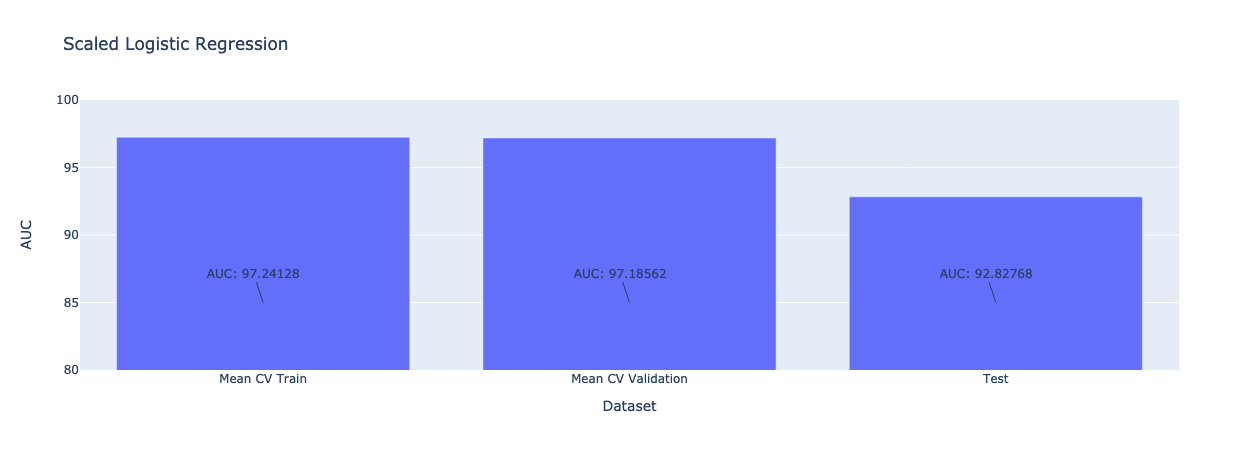

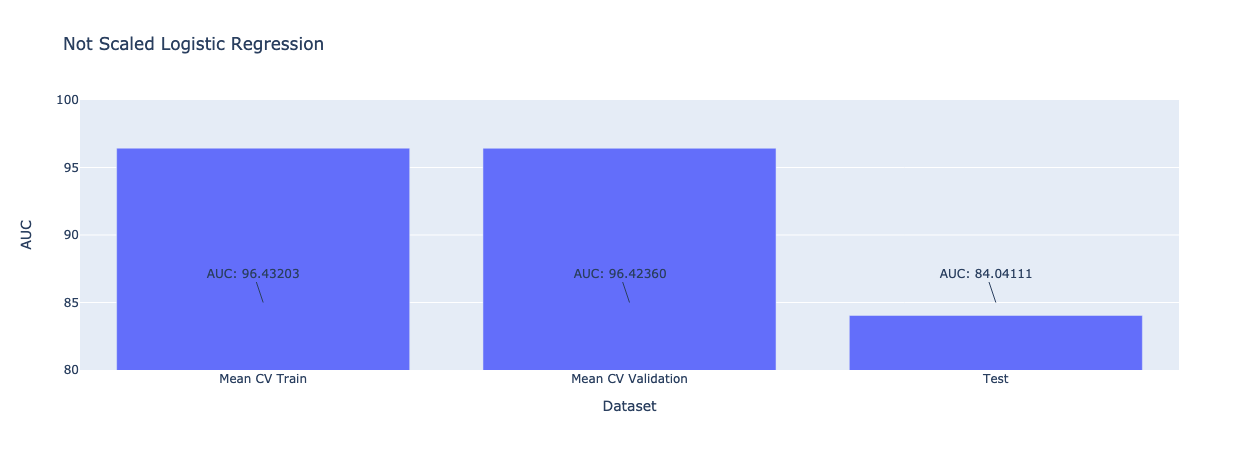

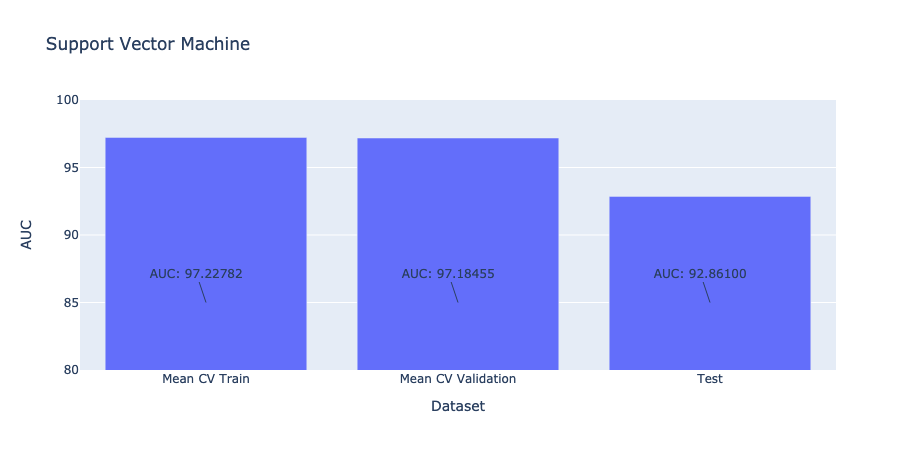

In [20]:
scaled_model= {
    "Mean CV Train": scaled_summary[scaled_summary["rank_validation_score"]==1].mean_train_score.values[0]*100 , 
    "Mean CV Validation": scaled_summary[scaled_summary["rank_validation_score"]==1].mean_validation_score.values[0]*100,
    "Test": get_auc( y_test, y_hat_lg_scaled)*100
}

not_scaled_model= {
    "Mean CV Train":  not_scaled_summary[not_scaled_summary["rank_validation_score"]==1].mean_train_score.values[0]*100, 
    "Mean CV Validation": not_scaled_summary[not_scaled_summary["rank_validation_score"]==1].mean_validation_score.values[0]*100,
    "Test": get_auc( y_test, y_hat_lg_not_scaled)*100
}

svm_model= {
    "Mean CV Train":  svm_summary[svm_summary["rank_validation_score"]==1].mean_train_score.values[0]*100, 
    "Mean CV Validation": svm_summary[svm_summary["rank_validation_score"]==1].mean_validation_score.values[0]*100,
    "Test": get_auc( y_test, y_hat_svc)*100
}

def make_bar_plot_per_model(df, title):
    df  = pd.DataFrame.from_dict(df, orient="index").reset_index()
    df = df.rename(columns={0: "AUC", "index": "Dataset"})
    fig = px.bar(df, x='Dataset', y="AUC", title=title)
    fig.add_annotation(text = f'AUC: {df[df["Dataset"]=="Mean CV Train"].AUC[0]:.5f}', x="Mean CV Train",y=85)
    fig.add_annotation(text = f'AUC: {df[df["Dataset"]=="Mean CV Validation"].AUC[1]:.5f}', x="Mean CV Validation",y=85)
    fig.add_annotation(text = f'AUC: {df[df["Dataset"]=="Test"].AUC[2]:.5f}', x="Test",y=85)
    fig.update_yaxes(range=[80,100])
    fig.show()
    
    
    
make_bar_plot_per_model(scaled_model, "Scaled Logistic Regression")
make_bar_plot_per_model(not_scaled_model, "Not Scaled Logistic Regression")
make_bar_plot_per_model(svm_model, "Support Vector Machine")


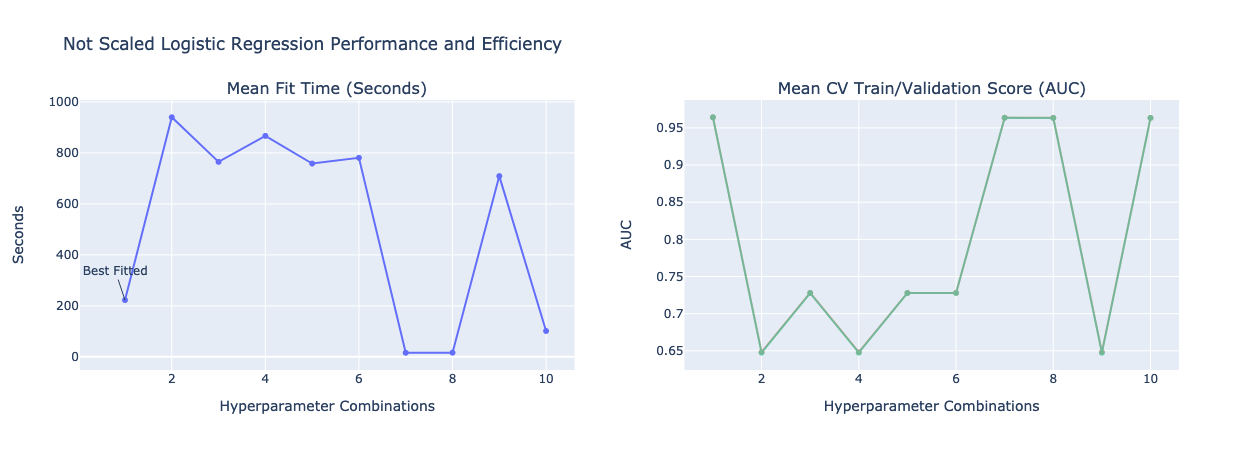

In [21]:
lr_results_cols = ["mean_fit_time", "param_model__solver", "param_model__penalty", "param_model__C", "mean_validation_score", "rank_validation_score"]
plot(not_scaled_summary, "Not Scaled Logistic Regression")

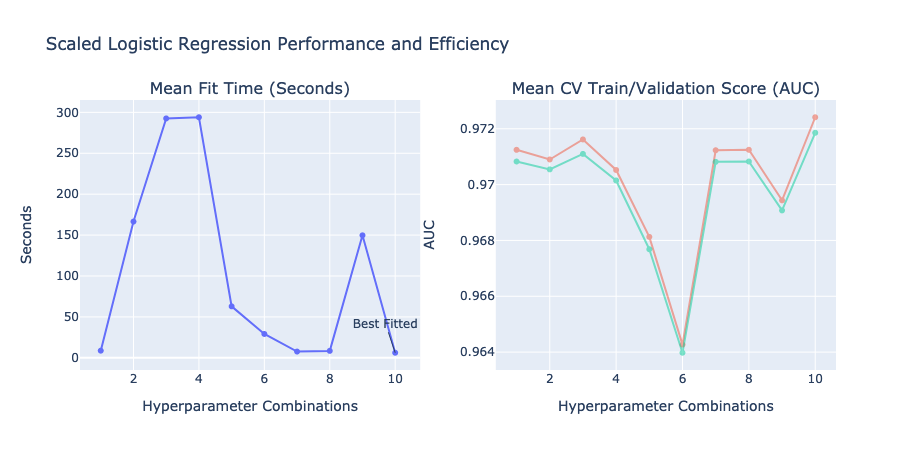

In [22]:

scale_plot = plot(scaled_summary, "Scaled Logistic Regression")


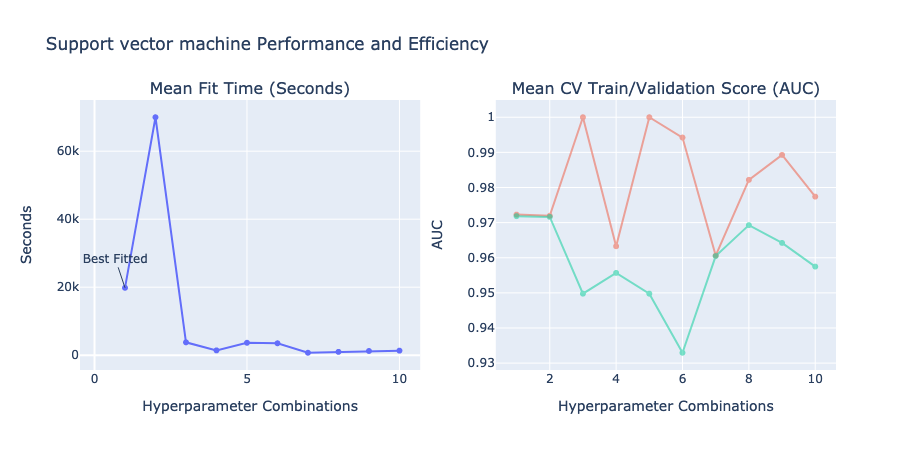

In [23]:
plot(svm_summary, "Support vector machine")

## Interpret Feature Importance

To assess feature importance for our models, specifically for our Scaled Logistic Regression model, we extracted feature importance via variable estimates for our encoded and standardized variables. We then ploted the relative feature importance of numerical and categorical variables independently. This was done because while we standardized our numerical variables, we implemented a one hot encoding strategy for our categorical variables. As such, the two types of variables are on different scales. Subsequently, we ploted the 12 most important categorical variables and 8 most important numerical variables. 

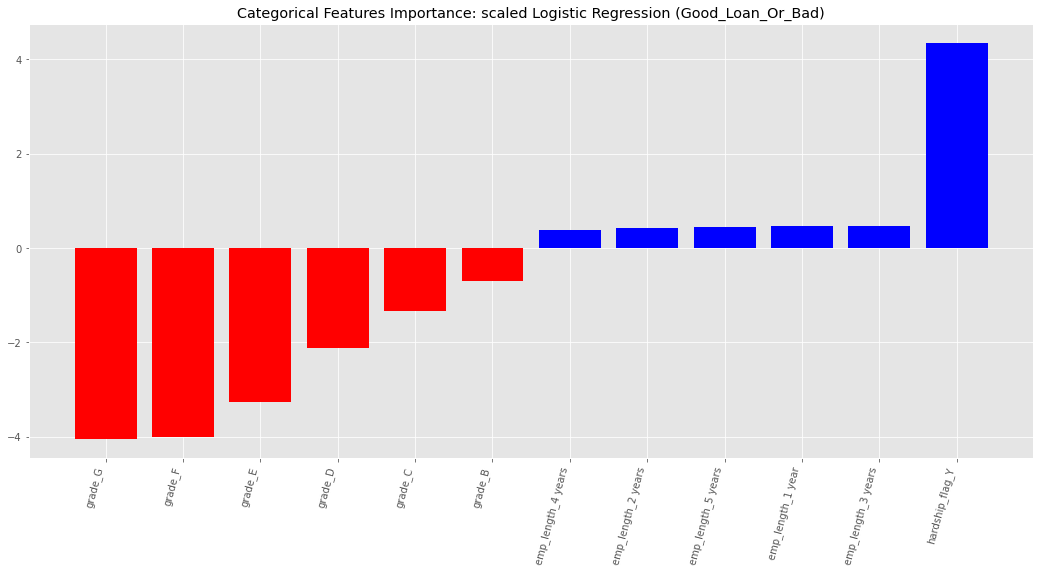

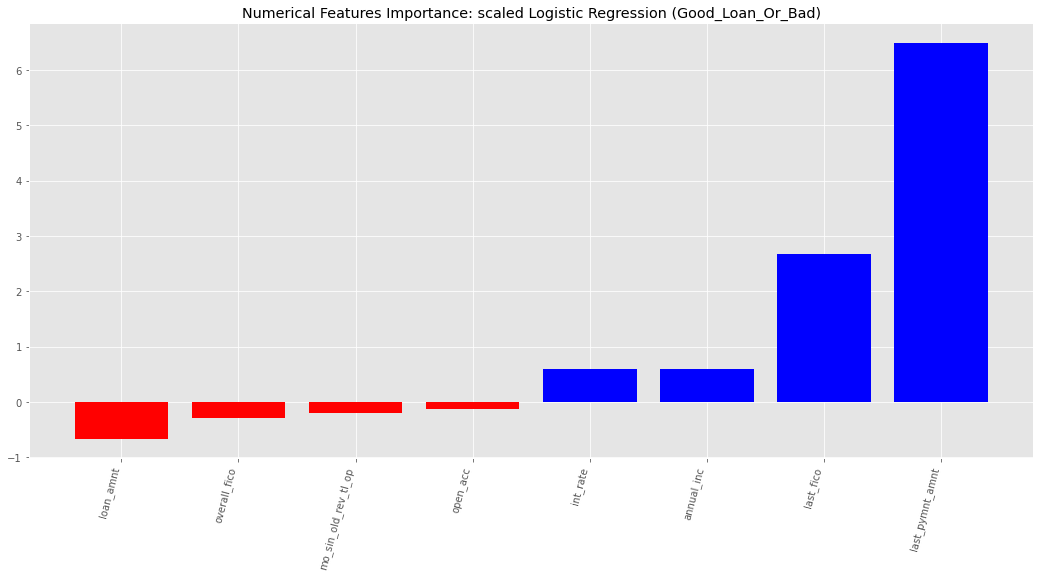

In [24]:
# Todo: refactor this to a common util library
# Todo: refactor "__added__name__" into a parameter with a default value. 
def get_feature_names(column_transformer):
    """Get feature names from transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    
    # by nesting functions, we know that when this method is executed, it has the columns from the transformer at the current hierarchical level. 
    def get_feature_names_inner(trans):
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):

                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)

                return ['x%d' % i  for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                # levels
                return [name + "__added__name__" + f for f in column]
        return [name + "__added__name__" + f for f in trans.get_feature_names(column)]
    
    ### Start of processing
    feature_names = []

    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))

    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            _names = get_feature_names_inner(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__added__name__" + column + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_feature_names_inner(trans))

    return feature_names

def plot_coefficients(feature_importances, top_features, title):
    feature_importances.sort(key=lambda x:x[1])
    top_positive_feature_importances = feature_importances[-top_features:]
    top_negative_feature_importances = feature_importances[:top_features]
    top_feature_importances = top_negative_feature_importances + top_positive_feature_importances
    unziped_top_feature_importances = list(zip(*top_feature_importances))
    unziped_top_feature_names = np.array(list(unziped_top_feature_importances[0]))
    unziped_top_feature_estimates= np.array(list(unziped_top_feature_importances[1])).astype(float)
    
    # create plot
    plt.figure(figsize=(18, 8))
    colors = ['red' if feature_estimate < 0 else 'blue' 
              for (feature_name, feature_estimate) in top_feature_importances]
    
    plt.bar(unziped_top_feature_names, unziped_top_feature_estimates, color=colors)
    plt.xticks(np.arange(0,  2 * top_features), unziped_top_feature_names, rotation=75, ha='right')
    plt.title(title)
    plt.show()

best_estimator = search_lr_scaled.best_estimator_
column_transformer = best_estimator.named_steps['preprocessing']
variable_importance_model = best_estimator.named_steps['model']
features_list = get_feature_names(column_transformer)

feature_importances = [feature_importance for feature_importance in zip(features_list, variable_importance_model.coef_.ravel())]

cat_feature_importances = [(feature_name.replace('cat__added__name__', ''), feature_estimate) 
                      for feature_name, feature_estimate in feature_importances 
                      if feature_name.startswith('cat__added__name__')]

numerical_feature_importances = [(feature_name.replace('scale__added__name__', ''), feature_estimate) 
                      for feature_name, feature_estimate in feature_importances 
                      if feature_name.startswith('scale__added__name__')]
    

plot_coefficients(cat_feature_importances, 6, 'Categorical Features Importance: scaled Logistic Regression (Good_Loan_Or_Bad)')
plot_coefficients(numerical_feature_importances, 4, 'Numerical Features Importance: scaled Logistic Regression (Good_Loan_Or_Bad)')

Overall you can see that there are 3 categorical features (with their different levels) and 4-5 numerical variables that have the highest "importance" as defined by their scaled logistic regression coefficients. It is important to note that the Blue values in the importance plots above indicate positive association between the odds of a loan having a good outcome, whereas red indicates the opposite. 

#### Categorical Feature importance 
As can be seen, with regards to predicting whether the outcome of a loan will be good or bad, the top 12 categorical treatments include the features `grade`, `employment length` and the `hardship_flag`. 

1. Grade (levels B, C, D, E, F and G): 
This makes sense as loan grades are determined primarily to assist lenders when forecasting risk for a particular loan. This risk grade is meant to then be used to determine how high the interest rate must be for a lender to, on average, compensate for the heightened risk associated with a loan that is more likely to be `bad`. Further it can be noted that the lower grades have a higher feature importance with respect to the outcome of a loan. For example, Grade G and F have much more correlation with the outcome of a loan than grades C or B. Grade A isn't even in the top 12 most important categorical features for scaled logistic regression. This indicates that financial distress or low credit is a predictor of loan outcome. Notice that the bad loan grades negatively correlate to an increase in the odds of a loan outcome being good. 

2. Hardship Flag:
A Hardship flag indicates that a loan is in a hardship plan. A Lending Club hardship loan (as defined here: https://www.bbb.org/us/ca/san-francisco/profile/financial-services/lendingclub-corporation-1116-361746/complaints) indicates that a lender can make interest only payments and is under financial distress. This flag then correlates to the outcome of a loan in an interesting way. It appears to be positively associated with the odds of a loan being good. This might be true because when a loan is put under this category, it allows the loaner to pay off their other debts and get back on their feet. They don't incur additional interest and late fees because of the special category their loan is in.  

3. Employment Length:
Employment Length appears to also be a somewhat important factor with respect to loan outcomes. This makes sense, as basically being employed indicates that a loan holder will be more likely to pay off their loan because they have an income stream. 

#### Numerical Feature importance 
As can be seen, with regards to predicting whether the outcome of a loan will be good or bad, the top 8 numerical attributes. This list included the features `last payment amount`, `last FICO score`, `annual income`, `loan amount`, and `interest rate`  

1. Last Payment Amount: 
The factor with the highest importance of all numerical features, `Last Payment Amount` is a strong predictor of the outcome of a loan. This makes a lot of sense, the higher the last payment amount was, the more likely that a loan will be paid off. Loans that have high principals may have high payments. However, the majority of the time, a higher payment amount most likely correlates to a loan holder's ability and willingness to pay off a given loan. 

2. Last FICO Score: 
The higher the last FICO score for a loan holder, the more likely they are to pay off a loan. This is reflected by the positive association between the odds of a loan being good and a loan holder's last FICO score. FICO scores aggregate data such as the Amounts Owed, Payment History, New Credit, Length of Credit History, etc. 

3. Loan Amount: 
Interestingly, loan amount negatively correlates with the outcome of a loan. This makes sense because a lender is taking on more financial risk when they lend a larger amount. Larger loans may take longer to pay off and that allows more time for something to go wrong in the lifecycle of a given loan.

4. Annual Income: 
There is a positive correlation between annual income and the odds of a loan outcome being good. The more a loan holder makes per year, the more likely they are to pay off their loan. 

5. Interest Rate: 
Interest rate appears positively correlated with the odds of a loan outcome being good. This is interesting because it would seem like the interest rate for a loan would be set higher because a loan was more likely to end badly (aka risk). However, the opposite seems to be true. The higher the interest rate on a loan, the higher the odds of the outcome being good. This could be because the odds of larger loans being paid off are higher and larger loans have higher interest rates.



## Interpret Support Vectors

In [25]:
# Extract Support Vectors
df_support = X_train.iloc[search_svc.best_estimator_.named_steps['model'].support_,:].copy()
df_support['good_loan_or_not'] = y_train.to_frame().iloc[search_svc.best_estimator_.named_steps['model'].support_,0]

In [26]:
df_train = X_train.copy()
df_train['good_loan_or_not'] = y_train.to_frame().iloc[:,0]

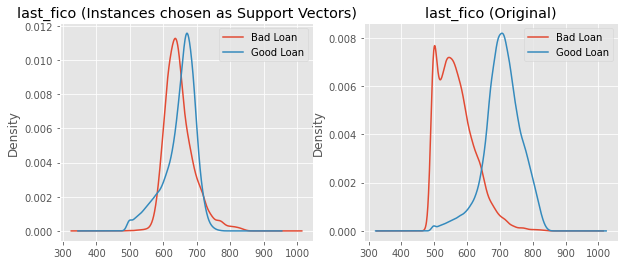

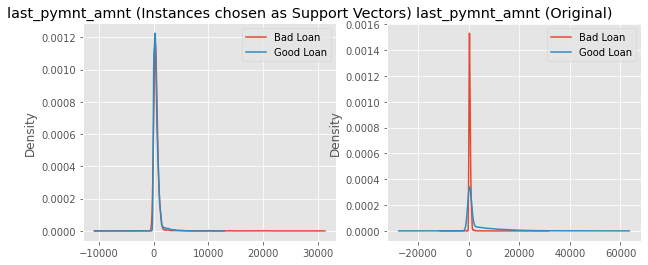

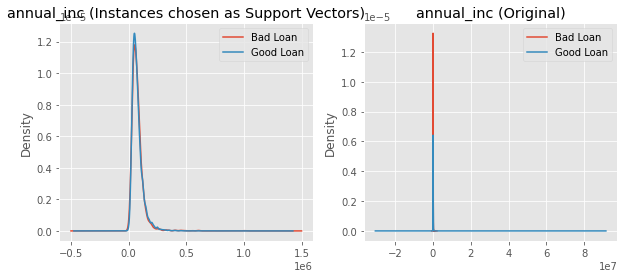

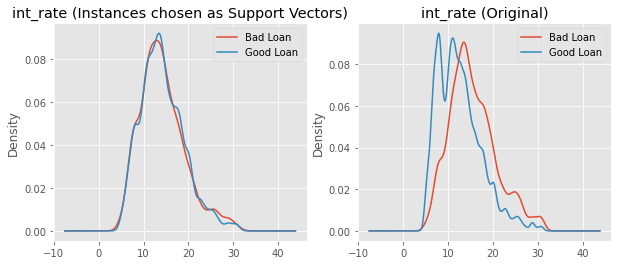

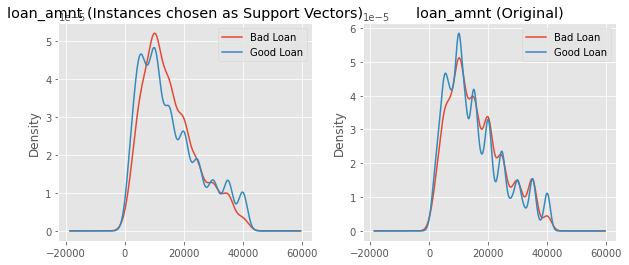

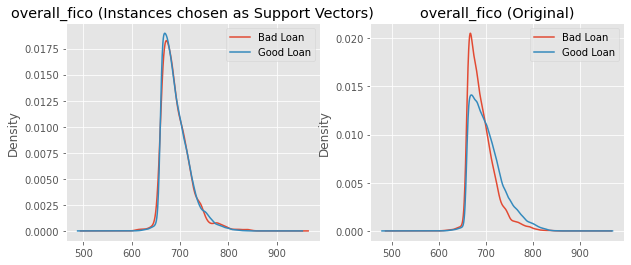

In [27]:
# now lets see the statistics of these attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['good_loan_or_not'])
df_grouped = df_train.groupby(['good_loan_or_not'])

# plot KDE of Different variables
vars_to_plot = ['last_fico','last_pymnt_amnt','annual_inc','int_rate','loan_amnt','overall_fico']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Bad Loan','Good Loan'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Bad Loan','Good Loan'])
    plt.title(v+' (Original)')

#### Summary for Chosen Support Vectors

The distribution plots above compare instances chosen as support vectors (left) with the original training data set (right). Within each plot, we can observe the distribution of a particular variable plotted by the response levels. "Good Loans" are plotted in blue and "Bad Loans" are plotted in red. The variables shown above include: `last_fico`, `last_pymnt_amnt`, `annual_inc`, `int_rate`, `loan_amnt`, `overall_fico`. We chose to plot numeric variables we deemed important. Importance was determined through EDA (lab 1), variable importance rank by Gini scores in our random forest model (lab 1), or the Feature Importance section of Logistic Regression above. It is worth noting many of these variables are constantly ranked as important across the various algorithms or metrics used.

By comparing the distributions of important numeric predictors between the support vectors and the original training data set, we can observe the better separation of response levels for the training data set across the board. This is because the support vectors selected by the linear kernel (the best model during our 10-fold cross validation) tend to be those either on the edge between two level boundaries or those misclassified in the training data set.

Text(0.5, 0.98, 'Training Data Set')

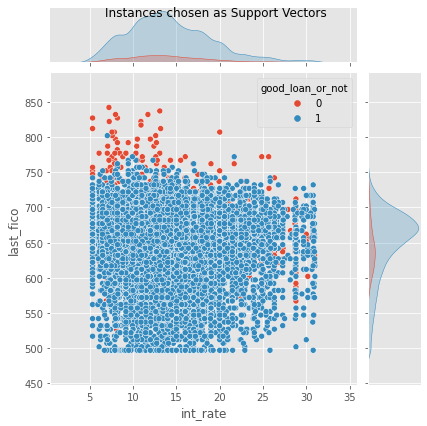

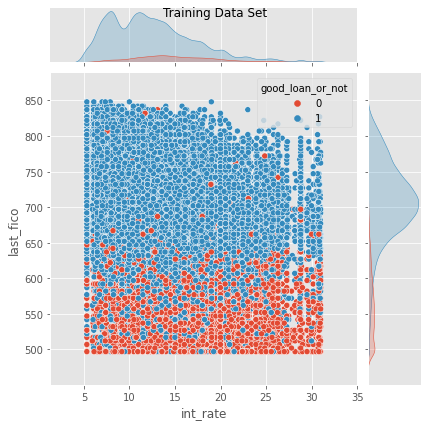

In [28]:
# Looking at Joint plots
sns.jointplot(x = 'int_rate',y='last_fico',hue='good_loan_or_not',data = df_support)
plt.suptitle("Instances chosen as Support Vectors")

sns.jointplot(x = 'int_rate',y='last_fico',hue='good_loan_or_not',data = df_train)
plt.suptitle("Training Data Set")

The joint plots above show `Last Fico Score` versus `Interest Rate` for the instances chosen as support vectors (top) and the entire training data set (bottom). We can see the separation between good loan and bad loan is much better for the entire training dataset compared to the instances chosen as support vectors. The two levels are mostly mixed together on the joint scatter plot when considering both `last fico score` and `interest rate` for chosen support vector instances (individual distributions were already analyzed above and are also shown on the jointplot). For the entire training data set, even though there are still some instances where good and bad loans mix together, the separation between the two levels is much better.

Text(0.5, 0.98, 'Training Data Set')

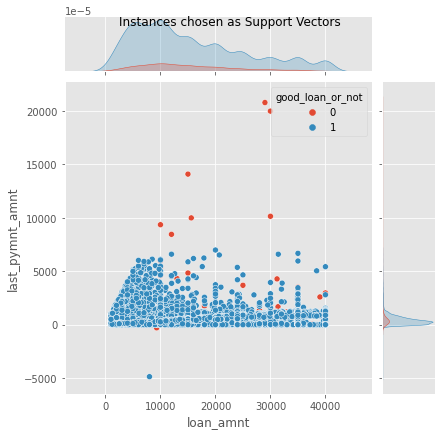

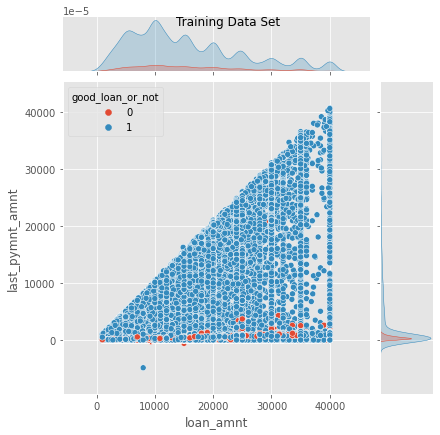

In [29]:
sns.jointplot(x = 'loan_amnt',y='last_pymnt_amnt',hue='good_loan_or_not',data = df_support)
plt.suptitle("Instances chosen as Support Vectors")

sns.jointplot(x = 'loan_amnt',y='last_pymnt_amnt',hue='good_loan_or_not',data = df_train)
plt.suptitle("Training Data Set")

Similarly, the joint plots above show `Last Payment Amount` versus `Loan Amount` for the instances chosen as support vectors (top) and the entire training data set (bottom). The bad loans seem to be more highly concentrated at the bottom of the training data set (low last payment amount) on the joint plot and good loans have a much wider distribution both on `Last Payment Amount` and `Loan Amount`. On the support vectors plot (top) we see most support vectors chosen are around low `Last Payment Amount`. Because most bad loans in the training data set are clustered on the bottom, it makes sense that good loans in that area would be chosen for support vectors. This shows the support vector instances are those instances that are close to the boundary or have been misclassified in the model.